**Summary:**

Fetch dataset from Kaggle (INRIAPerson) and apply some filtering for a nice set of data ready for training.

#Import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import json
import zipfile

In [2]:
%%capture
%%bash
git clone https://github.com/yanjiekee/adversarial_ki

In [3]:
# Warning because it's not installed as a python package, but it's available
# in the python system path
from adversarial_ki import input as inria

In [4]:
!pip install kaggle

# Define username and public api key gathered from your Kaggle Account
KAGGLE_USERNAME = 'eulerismygod'
KAGGLE_PUBLIC_API_KEY = '81c12f2b229dae9c3469e25df4c04838'
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_PUBLIC_API_KEY}

!mkdir /root/.kaggle

# Create .kaggle/kaggle.json file at the root for Kaggle API reference
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Download dataset and extract it to adversarial-person/data
!chmod 600 root/.kaggle/kaggle.json
!kaggle datasets download -d jcoral02/inriaperson

with zipfile.ZipFile('inriaperson.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/inriaperson/')

!rm inriaperson.zip

chmod: cannot access 'root/.kaggle/kaggle.json': No such file or directory
 98% 568M/582M [00:03<00:00, 171MB/s]
100% 582M/582M [00:03<00:00, 155MB/s]


In [5]:
# Clone the tensorflow models repository
%%capture
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [6]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

#Utils

In [7]:
%matplotlib inline

In [8]:
def plot_detection(img, boxes, classes, scores, category_index):
  
  image_np_with_annotations = img.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  
  plt.figure(figsize=(6, 6))
  plt.imshow(image_np_with_annotations)

def dataset_sanity_check(img_list_np, gt_list_np, category_index, index=None):

  length = len(img_list_np)

  if index is None:
    index = random.randrange(length)
  elif index >= length:
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(length)

  img = img_list_np[index]
  gt = gt_list_np[index]
  classes = np.ones((1, len(gt)))
  scores = None

  plot_detection(img, gt, classes, scores, category_index)

#Run

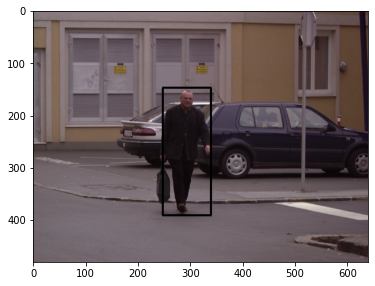

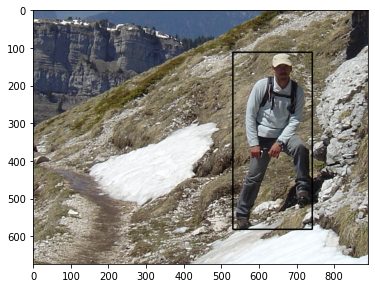

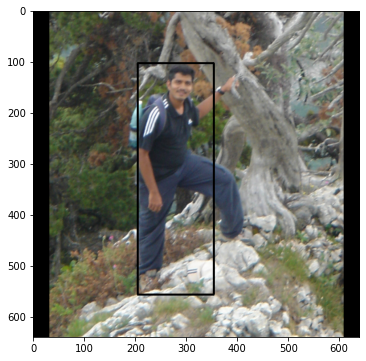

In [10]:
# Get dataset
test_img_dir = '/content/data/inriaperson/Test/JPEGImages'
train_img_dir = '/content/data/inriaperson/Train/JPEGImages'
test_gt_dir = '/content/data/inriaperson/Test/Annotations'
train_gt_dir = '/content/data/inriaperson/Train/Annotations'

# Fetch dataset
test_img_np, test_gt_np = inria.fetch(test_img_dir, test_gt_dir)
train_img_np, train_gt_np = inria.fetch(train_img_dir, train_gt_dir)
dataset_sanity_check(test_img_np, test_gt_np, inria.CATEGORY_INDEX)

# Filter dataset
test_img_np, test_gt_np = inria.filter_single_person(test_img_np, test_gt_np)
train_img_np, train_gt_np = inria.filter_single_person(train_img_np, train_gt_np)
dataset_sanity_check(test_img_np, test_gt_np, inria.CATEGORY_INDEX)

# Resize dataset
test_img_np, test_gt_np = inria.resize_with_pad(test_img_np, test_gt_np, 640, 640)
train_img_np, train_gt_np = inria.resize_with_pad(train_img_np, train_gt_np, 640, 640)
dataset_sanity_check(test_img_np, test_gt_np, inria.CATEGORY_INDEX)

# Tensorfy dataset
test_img_ts, test_gt_ts, test_class_ts = inria.tensorfy(test_img_np, test_gt_np, 90)
train_img_ts, train_gt_ts, train_class_ts = inria.tensorfy(train_img_np, train_gt_np, 90)

In [11]:
#SANITYCHECK
i = random.randrange(len(test_img_ts))
print(tf.shape(test_img_ts[i]))
print(test_gt_ts[i])
print(test_class_ts[i], '\n')

i = random.randrange(len(train_img_ts))
print(tf.shape(train_img_ts[i]))
print(train_gt_ts[i])
print(train_class_ts[i])

tf.Tensor([  1 640 640   3], shape=(4,), dtype=int32)
tf.Tensor([[0.3296875 0.39375   0.8609375 0.5578125]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 90), dtype=float32) 

tf.Tensor([  1 640 640   3], shape=(4,), dtype=int32)
tf.Tensor([[0.23728813 0.5772682  0.79062814 0.7417747 ]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 90), dtype=float32)
